# All plots for ANC paper


This notebook produces all the plots that we include in the ANC paper

In [3]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
plt.style.use('science')

# Section 2

In [244]:
from gwpy.timeseries import TimeSeries
from matplotlib import pyplot as plt
import scienceplots
import pandas as pd 
import numpy as np 

plt.style.use('science')

#Example from https://gwpy.github.io/docs/latest/spectrum/

#Channels that we will plot the ASD of
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR'
H1_string = 'H1:DCS-CALIB_STRAIN_C01_AR'


#Setelct some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)#10 mins later


#Get the data
print("get the data")
gwdata_L1   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_L1 = gwdata_L1.asd(8, 4) #Welch method. Also used in GWPy example

print("get data 2")
gwdata_H1   = TimeSeries.get(H1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_H1 = gwdata_H1.asd(8, 4) #Welch method. Also used in GWPy example


freqs_L1 = np.arange(len(spectrum_L1))*spectrum_L1.df
asd_L1 = np.array(spectrum_L1)

freqs_H1 = np.arange(len(spectrum_H1))*spectrum_H1.df
asd_H1 = np.array(spectrum_H1)

get the data
get data 2


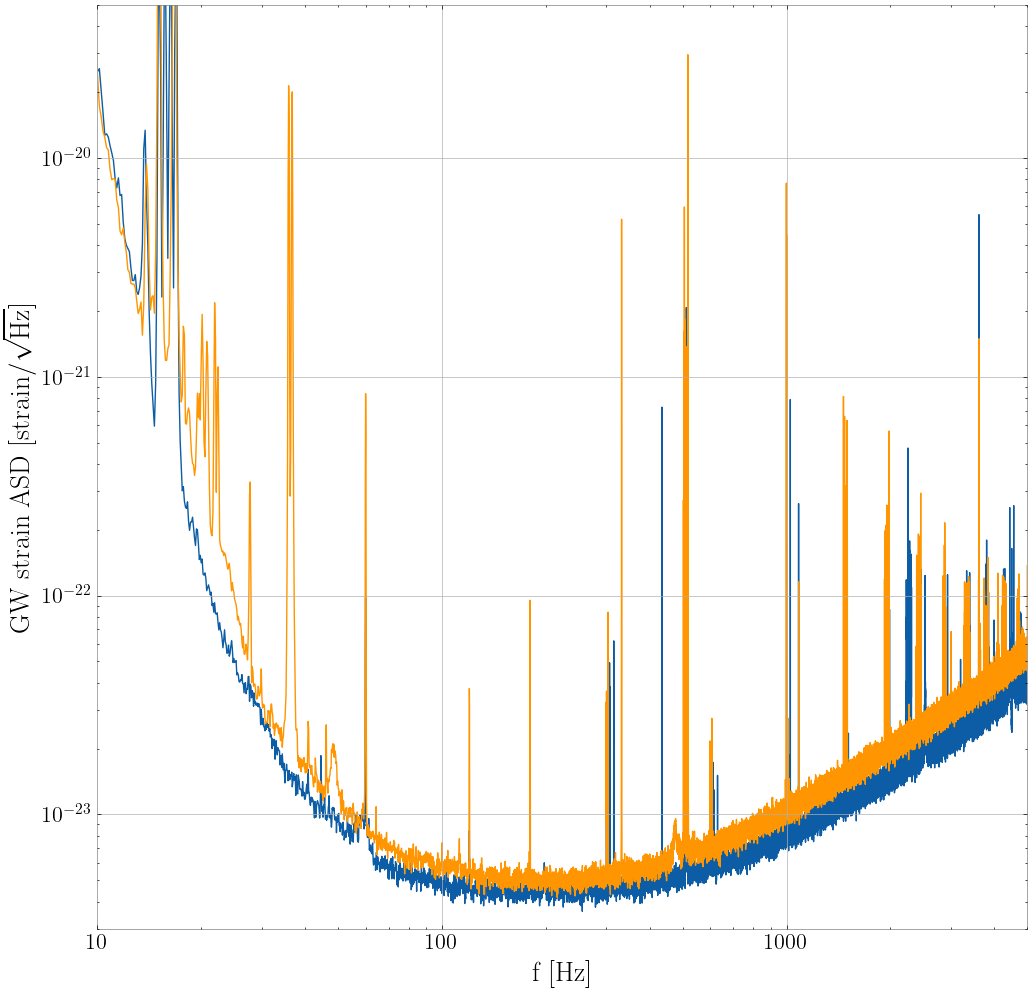

In [245]:



from matplotlib import pyplot as plt
import scienceplots
import glob
import numpy as np
plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(freqs_L1,asd_L1,c="C0")
ax.plot(freqs_H1,asd_H1,c="C2")



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.set_ylim(3e-24, 5e-20)


fs = 20
ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]',fontsize=fs)
ax.set_xlabel(r'f [Hz]',fontsize=fs)


ax.axes.tick_params(axis="both", labelsize=fs-4)



plt.savefig('../../data/manuscript_images/sensitivity_sq2.png',bbox_inches='tight',dpi=300)



#### Coherence plots


In [6]:
import pandas as pd 
from gwpy.timeseries import TimeSeries
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR' #strain channel

pem_channels = ['L1:PEM-CS_MAINSMON_EBAY_1_DQ',   
                 'L1:PEM-CS_MAINSMON_EBAY_2_DQ',
                 'L1:PEM-CS_MAINSMON_EBAY_3_DQ',
                 'L1:PEM-CS_MIC_LVEA_INPUTOPTICS_DQ',
                 'L1:PEM-EY_ACC_BEAMTUBE_MAN_Y_DQ',
                 'L1:PEM-EY_MAINSMON_EBAY_1_DQ',
                 'L1:PEM-EY_MIC_VEA_PLUSY_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_X_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_Y_DQ'
]


#Select some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)# 10 mins later


#Load the strain data
hoft   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

num_pem_channels = len(pem_channels)
fig, axes = plt.subplots(nrows=num_pem_channels, ncols=1, figsize=(10,18),sharex=True)

#Load the pem data and get the coherence w.r.t the strain channel

fs = 20
for i in range(num_pem_channels):


    pem = pem_channels[i]
    print(i, pem)
    #acc   = TimeSeries.get(pem,start=t0, end=t1,host='losc-nds.ligo.org')

    #Load the pem channel from disk
    acc = TimeSeries.read(f'../../data/pem_channels/{pem}.txt')

    
    #Coherence
    coh = hoft.coherence(acc, fftlength=2, overlap=1)


    coherence_frequencies = np.array(coh.frequencies)
    coherence_values = np.array(coh)


    ax = axes[i]

    ax.plot(coherence_frequencies,coherence_values)


    ax.set_xlim(1, 100)
    ax.set_ylim(0, 1)

    ax.set_ylabel(r'$C_{xy}$',fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    ax.set_title(pem)


    #ax.set_yscale('log')


axes[-1].set_xlabel(r'Frequency [Hz]',fontsize=fs)
fname='stacked_coherence_plot'
plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)



NameError: name 'pem_channels' is not defined

#### Cross-correlation of coherence plots 

In [30]:
fs = 20
i = 0
pem = pem_channels[i]
print(i, pem)
#Load the pem channel from disk
acc = TimeSeries.read(f'../../data/pem_channels/{pem}.txt')
hoft_downsampled = hoft.resample(acc.sample_rate)
acc.override_unit(hoft.unit) 



hoft_whitened = hoft_downsampled#.whiten()
acc_whitened = acc#.whiten()



cc = hoft_whitened.correlate(acc_whitened)



0 L1:PEM-CS_MAINSMON_EBAY_1_DQ


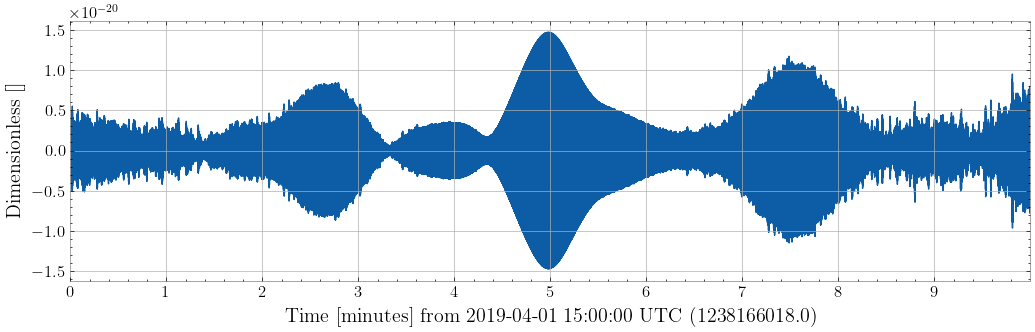

In [31]:
plot=cc.plot()

In [38]:
from scipy.fft import fft
y = fft(np.array(cc))

/Users/t1/miniconda3/envs/LIGO_ANC/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


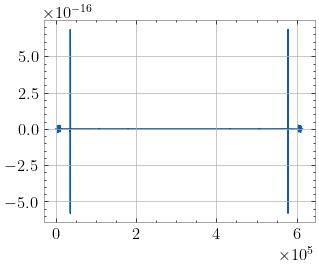

In [40]:
x = np.arange(len(y))

plt.plot(x,y)

In [ ]:

#Now cross correlate each strain channel with the PEM channel over this time period
from cross_correlate import check_plot
lag,cc = check_plot(t0,t1,strain_channel,aux,f'cross_correlation_{duration}_{strain_channel}_{aux}')


0 L1:PEM-CS_MAINSMON_EBAY_1_DQ


ValueError: TimeSeries x-axis sample sizes do not match: 6.103515625e-05 s vs 0.0009765625 s

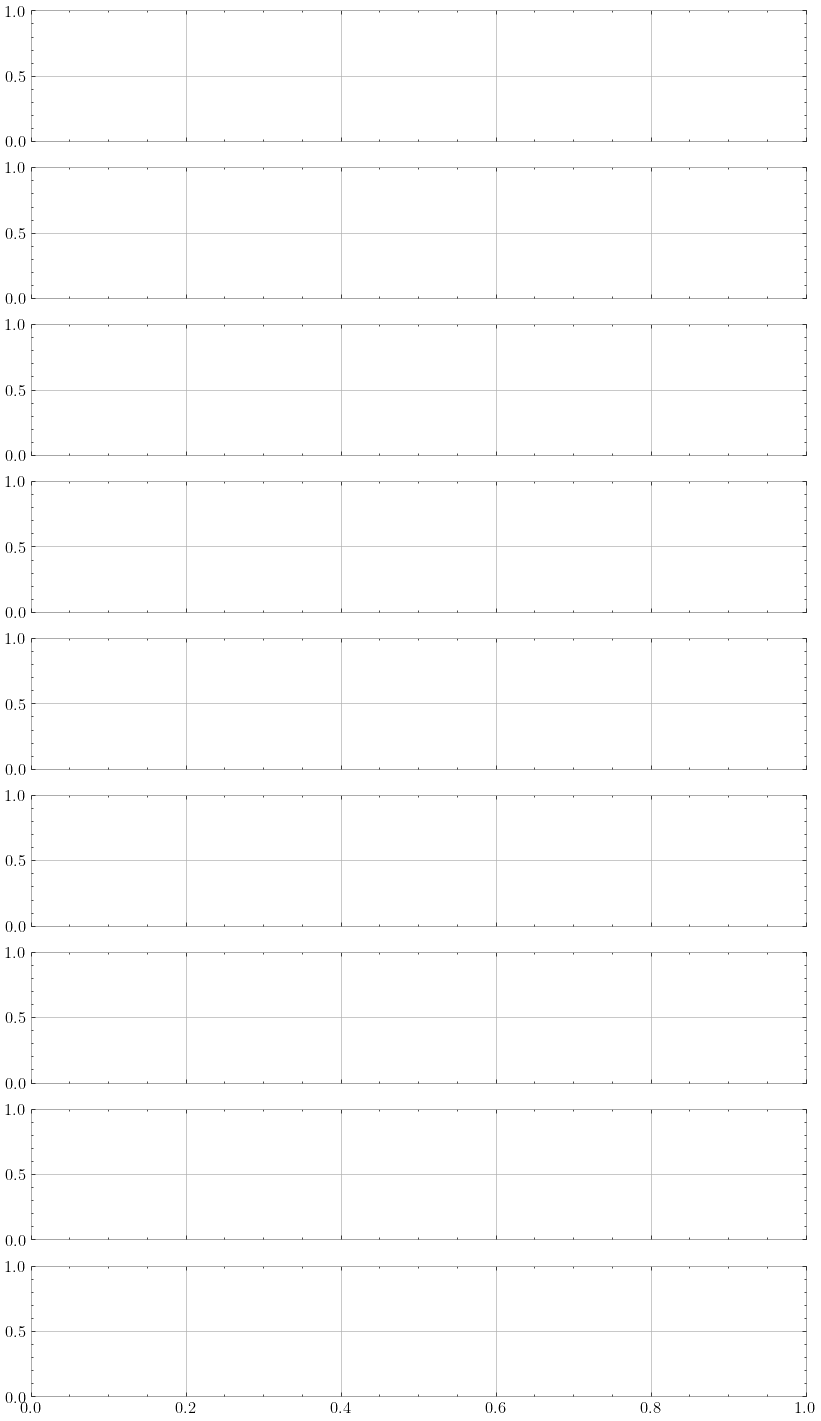

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

num_pem_channels = len(pem_channels)
fig, axes = plt.subplots(nrows=num_pem_channels, ncols=1, figsize=(10,18),sharex=True)

#Load the pem data and get the cross-correlation w.r.t the strain channel

fs = 20
for i in range(num_pem_channels):


    pem = pem_channels[i]
    print(i, pem)
    #acc   = TimeSeries.get(pem,start=t0, end=t1,host='losc-nds.ligo.org')

    #Load the pem channel from disk
    acc = TimeSeries.read(f'../../data/pem_channels/{pem}.txt')

    
    #cross-correlation
    cc = hoft.correlate(acc, fftlength=2, overlap=1)


    coherence_frequencies = np.array(coh.frequencies)
    coherence_values = np.array(coh)


    ax = axes[i]

    ax.plot(coherence_frequencies,coherence_values)


    ax.set_xlim(1, 100)
    ax.set_ylim(0, 1)

    ax.set_ylabel(r'$C_{xy}$',fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    ax.set_title(pem)


    #ax.set_yscale('log')


axes[-1].set_xlabel(r'Frequency [Hz]',fontsize=fs)
fname='stacked_coherence_plot'
#plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)



## Section 4B



### Fourier response of data before/after filtering 

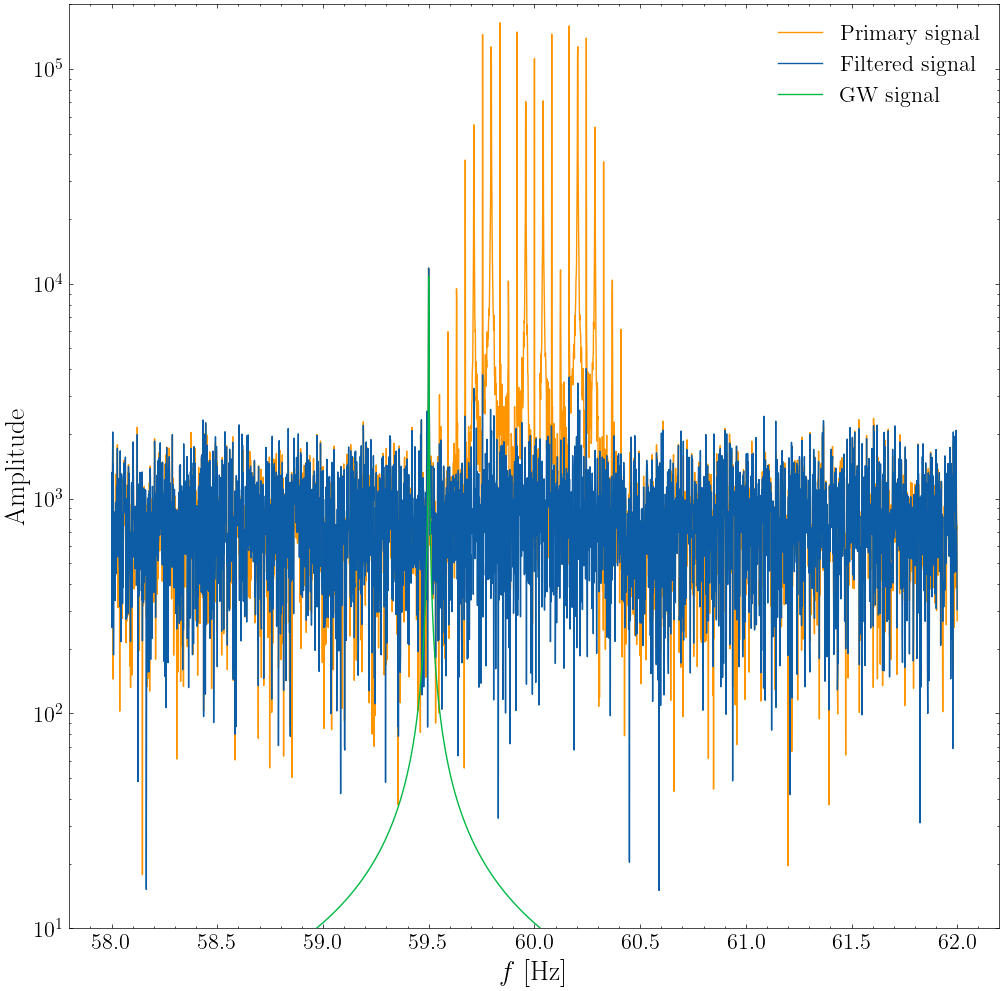

In [16]:
#Load the data
data = loadmat("../../data/fig_spectrum.mat")

C = data['C'].flatten()
Q = data['Q'].flatten()
S = data['S'].flatten()
w = data['w'].flatten() #frequencies



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(w,S,label="Primary signal",c='C2')
ax.plot(w,C,label="Filtered signal",c='C0')
ax.plot(w,Q,label="GW signal",c='C1')

# ax.plot(w,Q,label="GW signal")
# ax.plot(w,S,label="Primary signal")
# ax.plot(w,C,label="Filtered signal")



fs = 20
ax.set_ylabel(r'Amplitude',fontsize=fs)
ax.set_xlabel(r'$f$ [Hz]',fontsize=fs)


ax.set_yscale('log')
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

ax.set_ylim(1e1,2e5)

plt.savefig('../../data/images/spectrum',bbox_inches='tight',dpi=300)
plt.show()




### 2D Viterbi tracking plots 

In [87]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes





def mean_squared_error(data_true,data_predict):
    MSE = np.square(np.subtract(data_true,data_predict)).mean()
    return MSE





def load_data(path):

    data = loadmat(path)


    viterbi_with_pem = data['Y'] #Viterbi input matrix with PEM and GW. (131, 50)
    viterbi_without_pem = data['y'] # Viterbi input matrix with PEM cancelled #(131, 50)
    f = data['w0'].flatten()
    t = data['time'].flatten()


    GW_freq_true  = data['fq'].flatten()
    GW_freq_estim  = data['fhat_RLS'].flatten() #estimated GW frequency (with Viterbi) after the ANC

    return viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true,GW_freq_estim






def plot_2d(xbefore,xafter,f,t,GW_f_true1,GW_f_estim1,GW_f_true2,GW_f_estim2,vmin,vmax,fname=None,reverse_ordering=False,cmap='viridis'):

    #Plot figure
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,9),sharey=True)


    pos1 = ax1.imshow(xbefore, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200)
    pos2 = ax2.imshow(xafter, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200)

    
    lw = 2.0
    ls = '--'

    # manually reverse the ordering since it should go the other way around according to Sofia
    if reverse_ordering:
        GW_f_true1 = GW_f_true1[::-1] 
        GW_f_estim1 = GW_f_estim1[::-1] 


        GW_f_true2 = GW_f_true2[::-1] 
        GW_f_estim2 = GW_f_estim2[::-1] 



    #Plot the true GW frequencies on LHS
    ax1.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax1.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax1.scatter(GW_f_true1,t,c='C2')
    ax1.scatter(GW_f_true2,t,c='C1')

    #Plot true GW freqs on RHS
    ax2.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax2.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax2.scatter(GW_f_true1,t,c='C2')
    ax2.scatter(GW_f_true2,t,c='C1')


    #Plot estimates on RHS    
    ax2.plot(GW_f_estim1,t,c='C3',linewidth=lw,linestyle='dashed')
    ax2.plot(GW_f_estim2,t,c='y',linewidth=lw,linestyle='dashed')


    #Surface some error estimates
    MSE_low_noise = mean_squared_error(GW_f_true1,GW_f_estim1)
    MSE_high_noise = mean_squared_error(GW_f_true2,GW_f_estim2)

    print("Mean squared error in the frequency is:")
    print('MSE, low noise:', MSE_low_noise)
    print('MSe, high noise:', MSE_high_noise)






    fs = 20
    ax1.set_ylabel(r'Time [s]',fontsize=fs)
    ax1.set_xlabel(r'$f$ [Hz]',fontsize=fs)
    ax2.set_xlabel(r'$f$ [Hz]',fontsize=fs)

    ax1.axes.tick_params(axis="both", labelsize=fs-4)
    ax2.axes.tick_params(axis="both", labelsize=fs-4)


    plt.subplots_adjust(wspace=0.01)
    #ax2.spines['left'].set_color('white')


    axins = inset_axes(ax2, width = "5%", height = "100%", loc = 'lower left',
                       bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax2.transAxes,
                       borderpad = 0)
    fig.colorbar(pos2, cax = axins)

    axins.axes.tick_params(axis="both", labelsize=fs-4)
    axins.axes.set_ylabel(r'$ \left |\mathcal{F} \left[ x(t)\right] \right|^2$',rotation=0,fontsize=fs,labelpad=15)


    ax1.set_xlim(f[0],f[-1])
    ax1.set_ylim(t[0],t[-1])
    ax2.set_xlim(f[0],f[-1])
    ax2.set_ylim(t[0],t[-1])


    if fname is not None:
       plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)




    plt.show()








Mean squared error in the frequency is:
MSE, low noise: 0.0014117100877654501
MSe, high noise: 0.22380607056663052


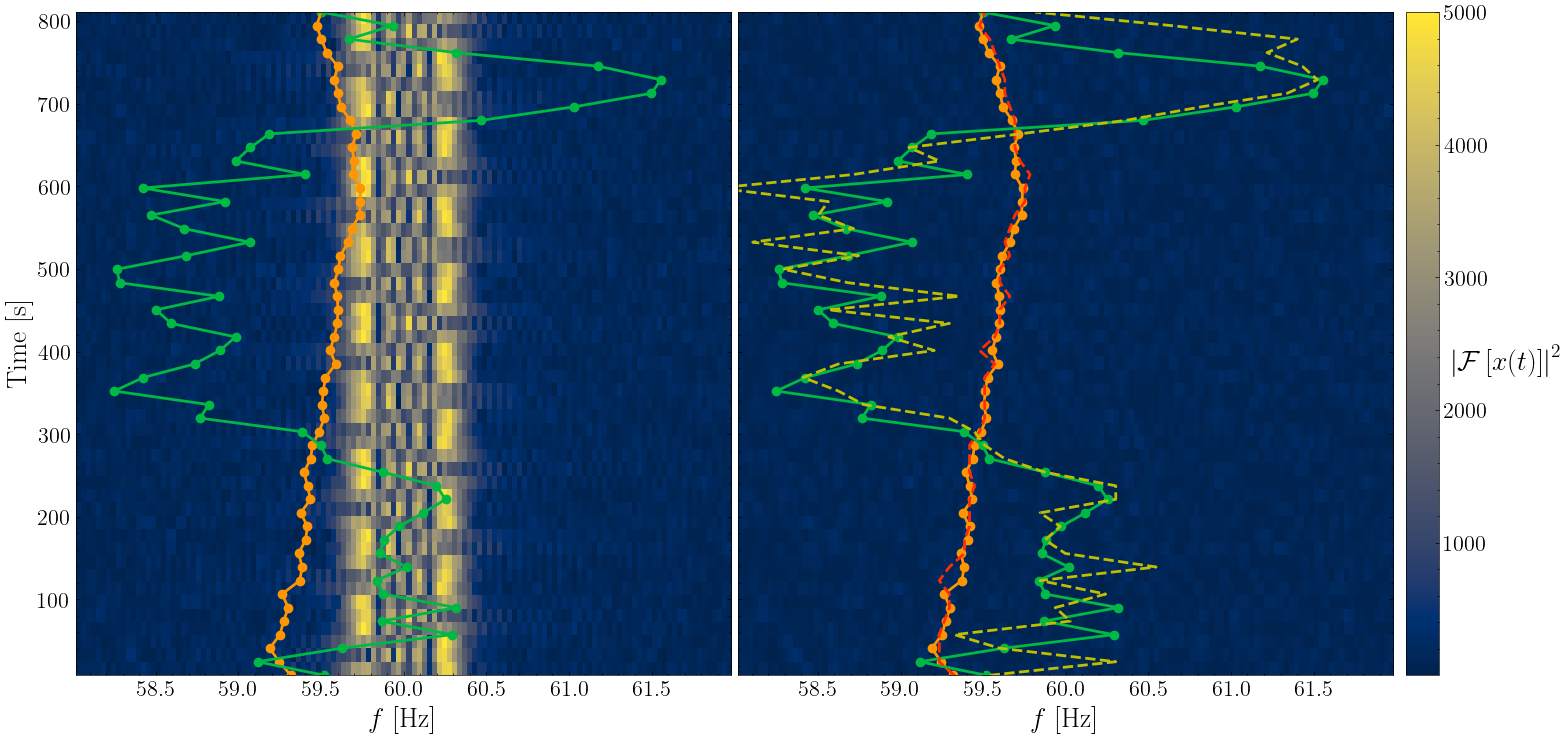

In [88]:
path1 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_1.mat"
viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true1,GW_freq_estim1 = load_data(path1)


path2 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_2.mat"
_,_,_,_,GW_freq_true2,GW_freq_estim2 = load_data(path2)



##Low contrast
cbar_lower_limit = 1
cbar_upper_limit = 5000
plot_2d(viterbi_with_pem.T,viterbi_without_pem.T,f,t,GW_freq_true1,GW_freq_estim1,GW_freq_true2,GW_freq_estim2,cbar_lower_limit,cbar_upper_limit,fname='viterbi_tracking_canonical',reverse_ordering=True,cmap='cividis')

# Section 4C

In this section we vary the power line parameters, for a single reference channel, and generate some ROC curves 

$ \Delta f = 0.0 \, , \gamma = 0.001$ Computed AUC using sklearn.metrics.auc: 0.67765
$\Delta f = 0.0 \, ,  \gamma = 0.01$ Computed AUC using sklearn.metrics.auc: 0.65315
$ \Delta f = 0.0 \, , \gamma = 0.1$ Computed AUC using sklearn.metrics.auc: 0.5529499999999999
$ \gamma = 0.02 \, , \Delta f = 0.25$ Computed AUC using sklearn.metrics.auc: 0.6231000000000001
$ \gamma = 0.02 \, ,  \Delta f = 0.5$ Computed AUC using sklearn.metrics.auc: 0.5787
$ \gamma = 0.02 \, , \Delta f = 1.0$ Computed AUC using sklearn.metrics.auc: 0.58465


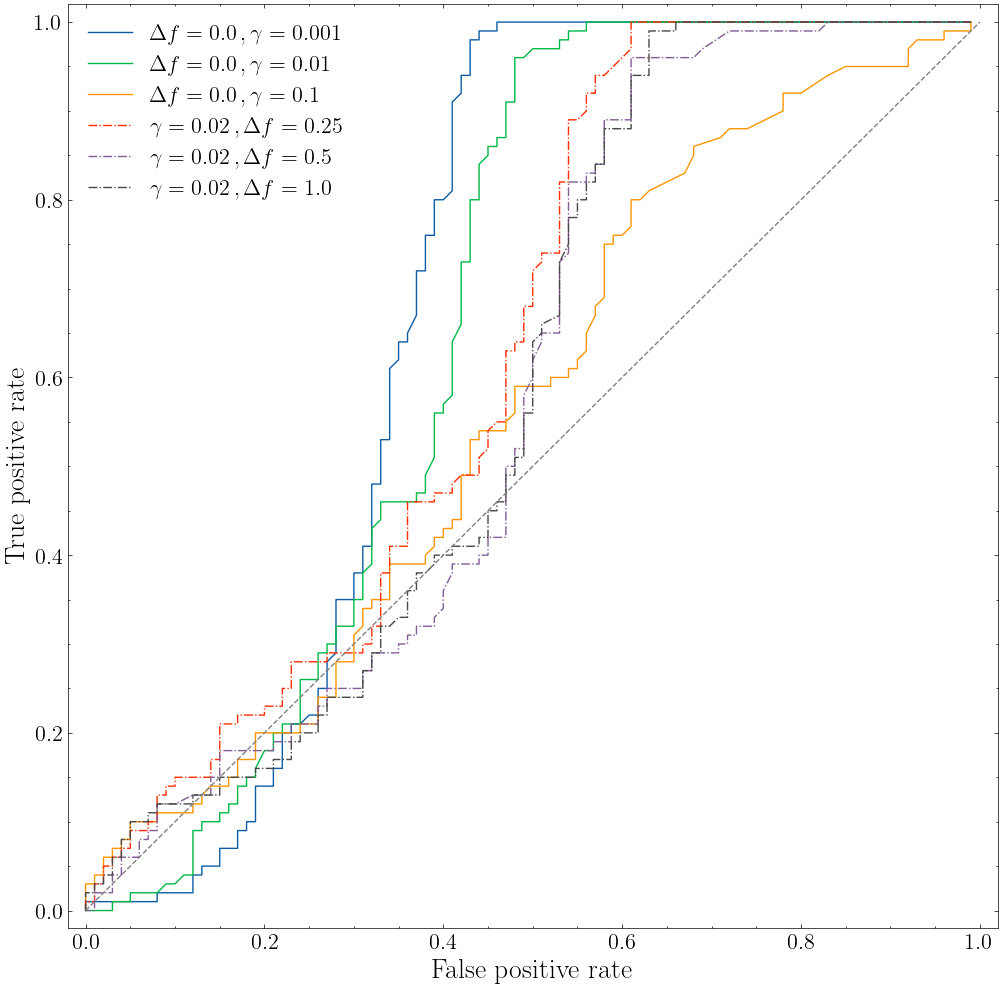

In [243]:

from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob 
import sys
from sklearn.metrics import auc

plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

labels1 = [r'$ \Delta f = 0.0 \, , \gamma = 0.001$', r'$\Delta f = 0.0 \, ,  \gamma = 0.01$',r'$ \Delta f = 0.0 \, , \gamma = 0.1$']
labels2 = [r'$ \gamma = 0.02 \, , \Delta f = 0.25$',r'$ \gamma = 0.02 \, ,  \Delta f = 0.5$',r'$ \gamma = 0.02 \, , \Delta f = 1.0$' ]


def load_and_plot(path,ax,labels,ls):


   

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)

    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i],linestyle=ls)

        #Also get the AUC e.g. https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_209

        print(labels[i], 'Computed AUC using sklearn.metrics.auc: {}'.format(auc(pfa,pd[i,:])))


load_and_plot(path1,ax=ax,labels=labels1,ls='solid') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,ax=ax,labels=labels2,ls='dashdot') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM



fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()






We can also plot them on separate axes if preferred...

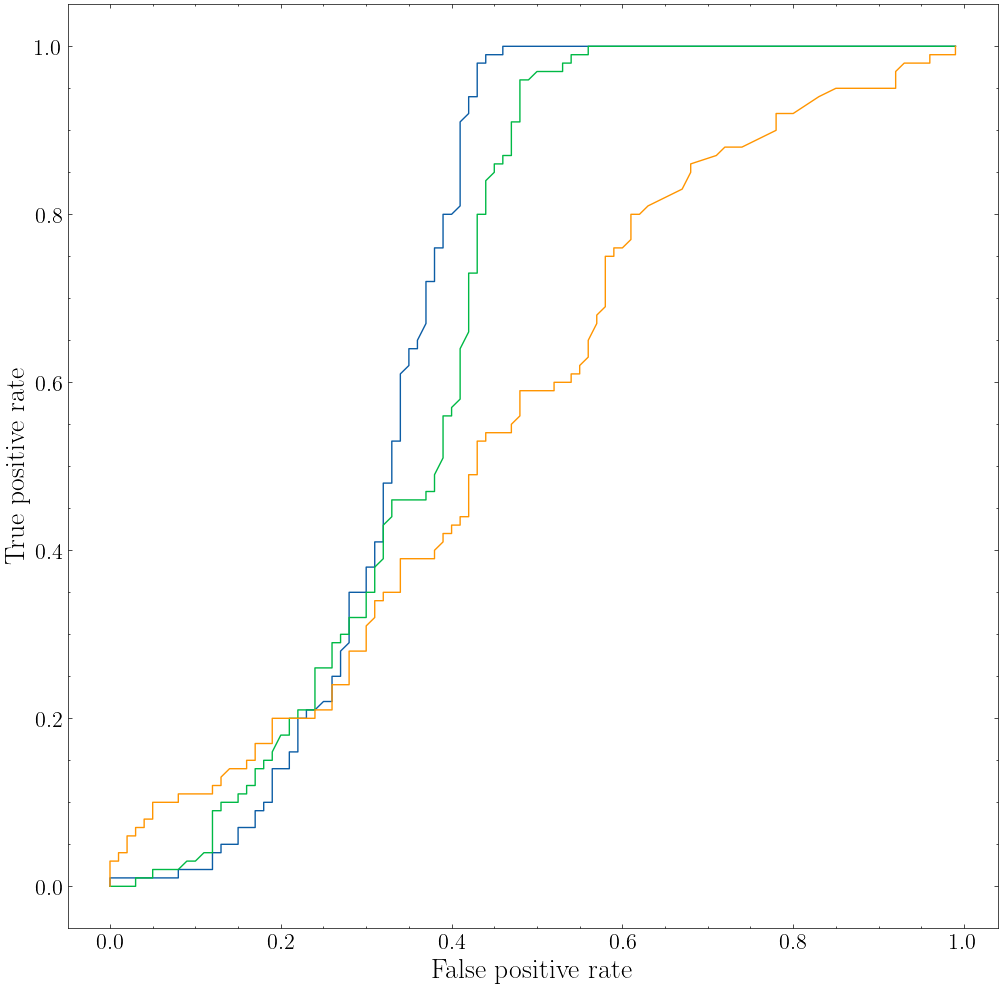

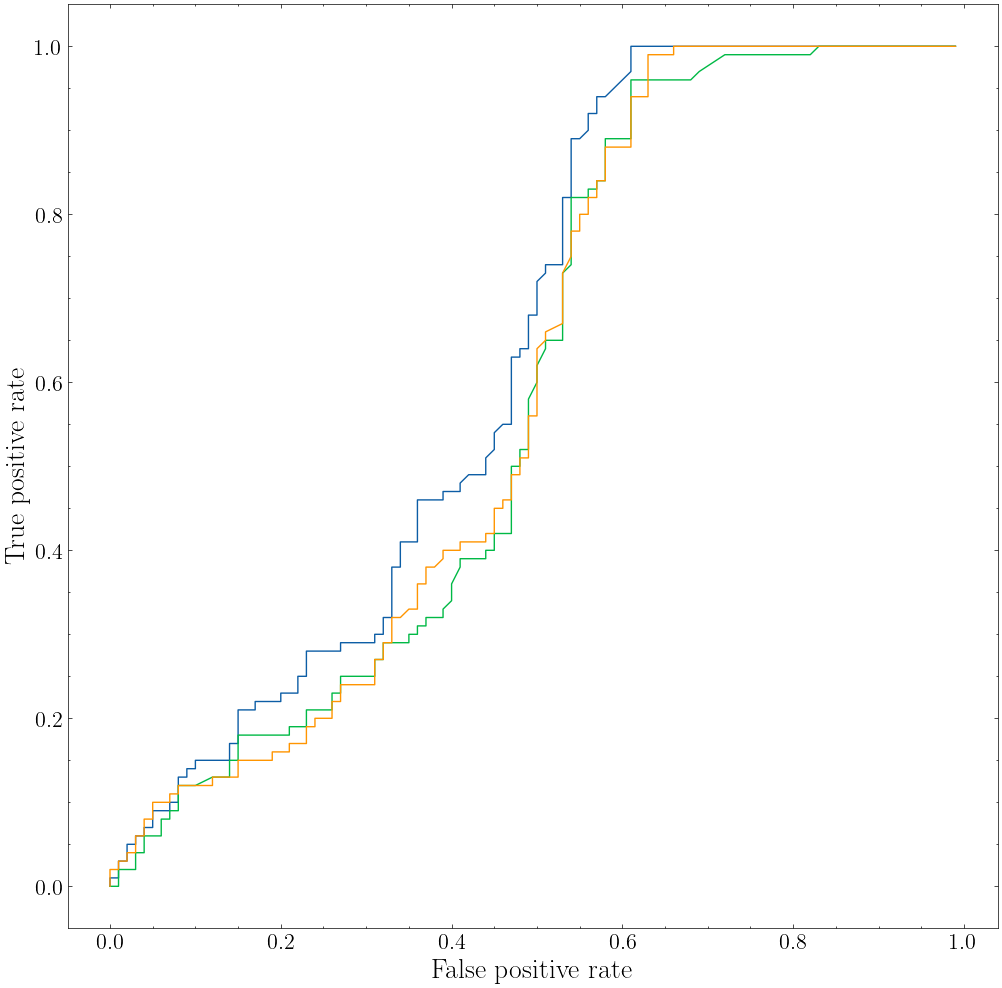

In [89]:
from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys

plt.style.use('science')







path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

import glob 





def load_and_plot(path,fname=None):


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)



    labels = [r'$\gamma = 0.001$', r'$\gamma = 0.01$',r'$\gamma = 0.1$']
    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i])




    fs = 20
    ax.set_xlabel("False positive rate",fontsize=fs)
    ax.set_ylabel("True positive rate",fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)


   
    if fname is not None:
        plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

    plt.show()
        



    
load_and_plot(path1,fname='example_powerline_roc_curve_1') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,fname='example_powerline_roc_curve_2') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM






# Section 4D



pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2
pd_h_002_gammah_001_df_0_ref_1
pd_h_002_gammah_001_df_0_ref_2
pd_h_002_gammah_001_df_05_ref_1
pd_h_002_gammah_001_df_05_ref_2
-----------------------
pd_h_002_gammah_0001_df_0_ref_1
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.97545
pd_h_002_gammah_0001_df_0_ref_2
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.9901499999999999
pd_h_002_gammah_001_df_0_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.8265999999999999
pd_h_002_gammah_001_df_0_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.8221499999999999
pd_h_002_gammah_001_df_05_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 1$ AUC: 0.9873000000000001
pd_h_002_gammah_001_df_05_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 2$ AUC: 0.9899999999999999
Reference AUC: 0.5450314017192998


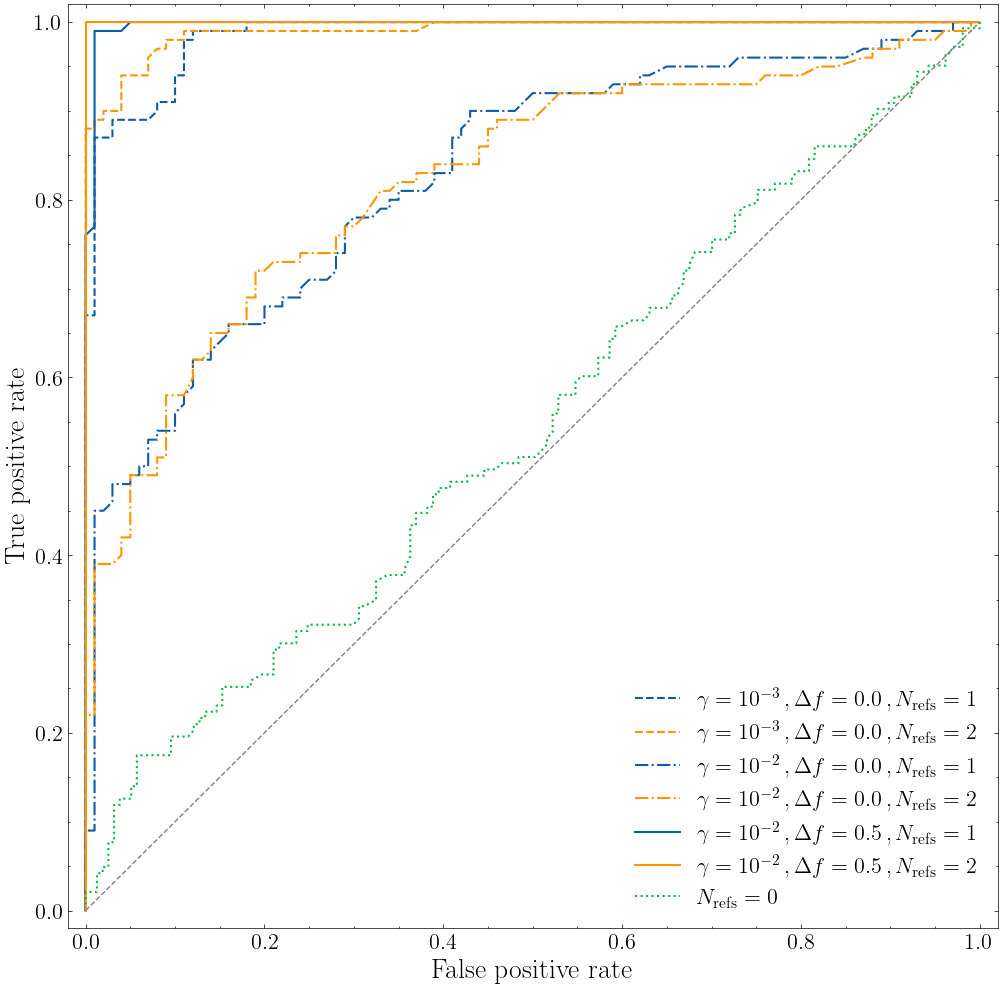

In [230]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    #excluded_keys = []
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys)& ~(k.endswith('M')))])
    
    l = len(list_of_keys)

    pd_keys = list_of_keys[0:int(l/2)]
    pfa_keys = list_of_keys[int(l/2):]
    colors = ['C0','C1','C2']
    colors = ['C0','C2']

    linestyles = ['dashed','dashdot','solid']
    color_index = 0
    line_index = 0


    #Some hacky slicing to put df=0.5 at the end
    pd_keys = pd_keys[0:2] + pd_keys[4:6] + pd_keys[2:4]
    pfa_keys = pfa_keys[0:2] + pfa_keys[4:6] + pfa_keys[2:4]

    for kk in pd_keys:
        print(kk)
    print('-----------------------')

    for k in range(len(pd_keys)):
        assert parse_keyname(pd_keys[k]) == parse_keyname(pfa_keys[k])
        h,gamma,delta_f,num_refs = parse_keyname(pd_keys[k])
        print(pd_keys[k])

        #label = [r'$\gamma = 0.001 \, , \Delta f = 0.0 \ , N_{\rm refs} = 0$']

        gamma = int(gamma)
        label = fr'$\gamma = 10^{{{gamma}}} \, , \Delta f = {delta_f} \, , N_{{\rm refs}} = {num_refs}$'

        pfa_key, pd_key = pfa_keys[k], pd_keys[k]

    
        ax.plot(data[pfa_key].flatten(),data[pd_key].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])

        print(label, 'AUC: {}'.format(auc(data[pfa_key].flatten(),data[pd_key].flatten())))
        
        color_index += 1

        if color_index > 1:
            color_index = 0
            line_index +=1



    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,linestyle='dotted',c='C1',label=r'$N_{\rm refs} =0$')
    print('Reference', 'AUC: {}'.format(auc(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten())))


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


#ax.set_xscale('log')
#ax.set_xlim(1e-3,1.0)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve_multi_ref' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()



Plot just one the diagonal result

pd_h_002_gammah_0001_df_0_NO_PEM
pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2


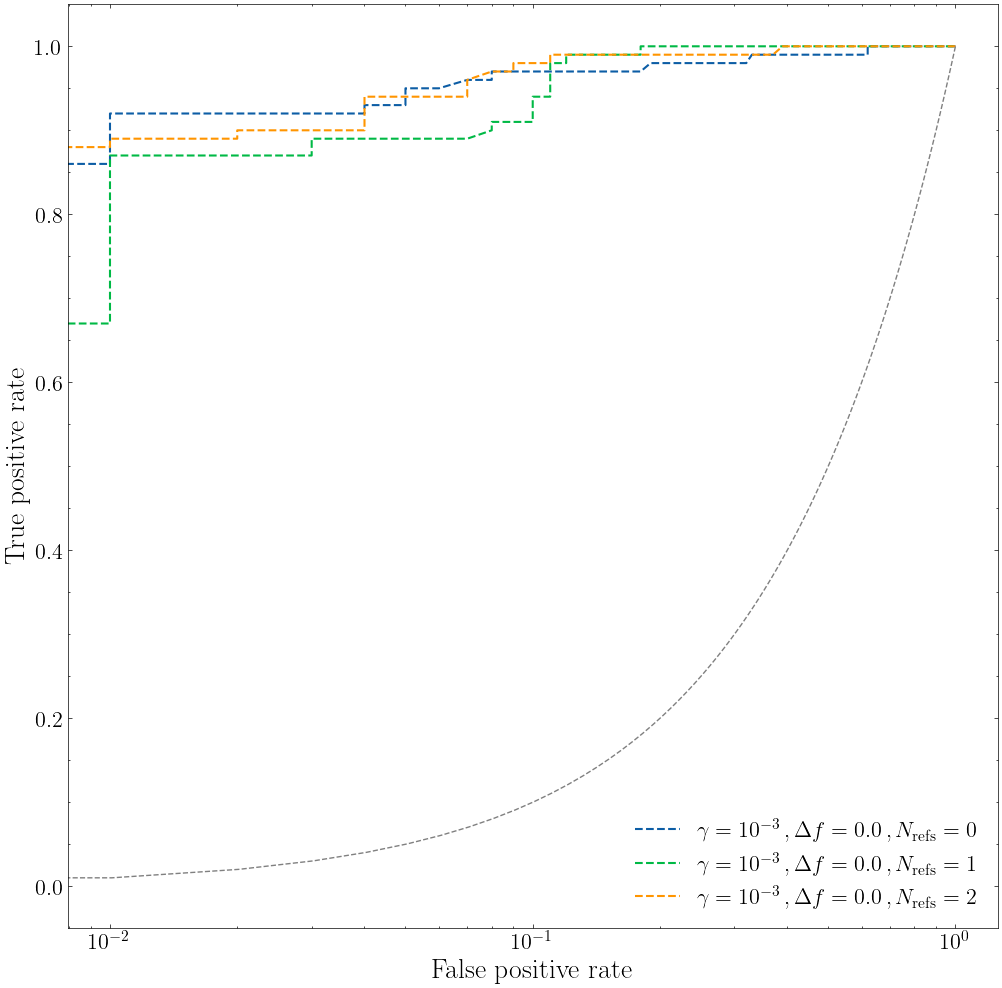

In [198]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

            


def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys))])
    
    
     

    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])
     


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



#delta = 0.05
#ax.set_xlim(0.0-delta,1.0+delta)
#ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

plt.show()



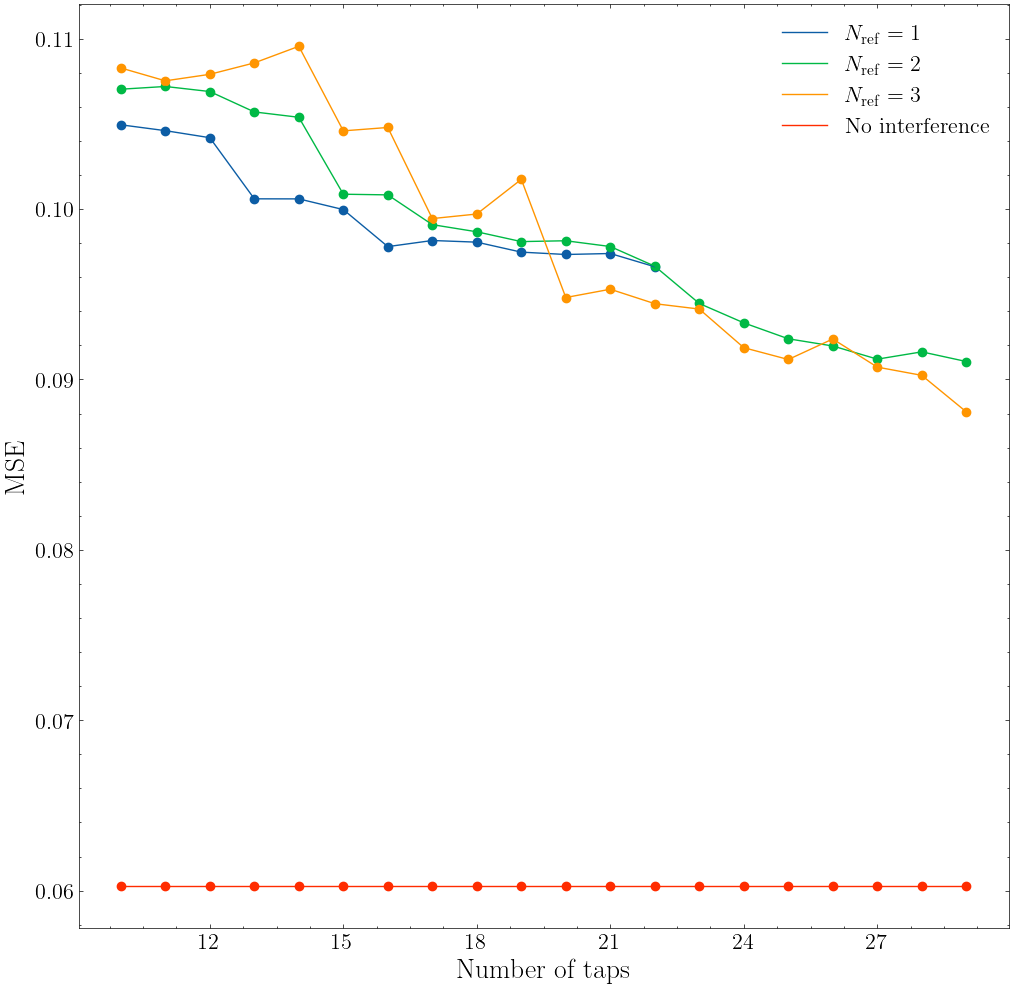

In [242]:
from scipy.io import loadmat
import numpy as np 
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt 

path = "../../data/filter_accuraacy.mat"

data = loadmat(path)
LL = data["LL"]
dw = data["dw"]
gamma = data["gamma"]
gamma_a = data["gamma_a"]
h = data["h"]



#Plot figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

labels = [r'$N_{\rm ref} = 1$', r'$N_{\rm ref} = 2$', r'$N_{\rm ref} = 3$', 'No interference']
for i in range(4):
    y = LL[i,:]
    x = np.arange(len(y))

    ax1.plot(x,y,label=labels[i])
    ax1.scatter(x,y)




fs = 20
ax1.set_ylabel(r'MSE',fontsize=fs)
ax1.set_xlabel(r'Number of taps',fontsize=fs)
ax1.axes.tick_params(axis="both", labelsize=fs-4)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(fontsize=fs-4)
  
fname = "taps_vs_error"
plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()
